In [1]:
import bw2io as bi
import bw2data as bd
import bw2calc as bc
import bw2analyzer as ba
import bw_temporalis as bwt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb

In [3]:
bd.projects

Brightway2 projects manager with 15 objects:
	Temporalis example project
	USEEIO-1.1
	bw_temporalis example
	default
	dynamic distribution example
	ecoinvent-3.9-cutoff
	ecoinvent=3.9-cutoff
	premise_ei39
	premise_ei39_2
	spreadsheet
	supply chain graph
	supply chain graph_0
	tictac
	tictac spring server
	tictac2
Use `projects.report()` to get a report on all projects.

In [4]:
bd.projects.set_current('tictac2')

In [5]:
bd.databases

Databases dictionary with 0 objects

# Temporal distribution for wind electricity (onshore) in `Europe`, corresponding to `remind SSP2 - 1150` IAM scenario

### Values 

In [6]:
a = np.array([0.79, 1.57, 3.6, 6.03, 8.73, 10.66, 11.27, 11.31])
a = a/np.sum(a) # normalizing the trend in Exajoules to get an actual TD

## Absolute TD

In [7]:
d = np.array([str(2010+k*10)+"-01-01" for k in range(8)])
d = np.array(d,dtype=np.datetime64)
print(d)

['2010-01-01' '2020-01-01' '2030-01-01' '2040-01-01' '2050-01-01'
 '2060-01-01' '2070-01-01' '2080-01-01']


<Axes: xlabel='Date', ylabel='Amount'>

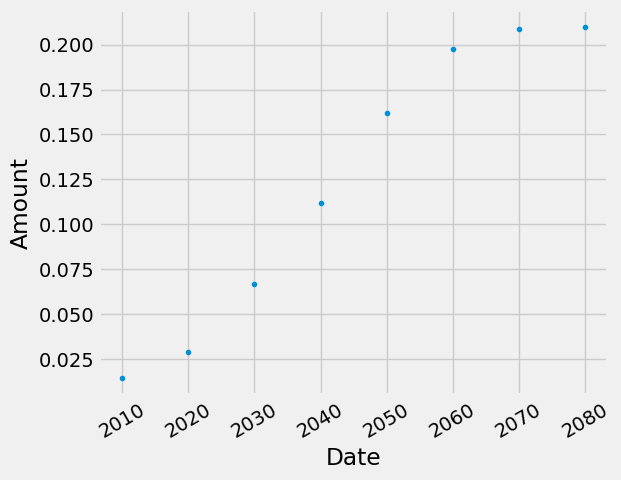

In [8]:
inc_wind_turbine_energy_absolute = bwt.TemporalDistribution(
    date=d,
    amount=a
)
inc_wind_turbine_energy_absolute.graph()

## Relative TD

In [9]:
delta = np.array([np.timedelta64(10*(k+1), 'Y') for k in range(8)])
print(delta)

[10 20 30 40 50 60 70 80]


<Axes: xlabel='Time (seconds)', ylabel='Amount'>

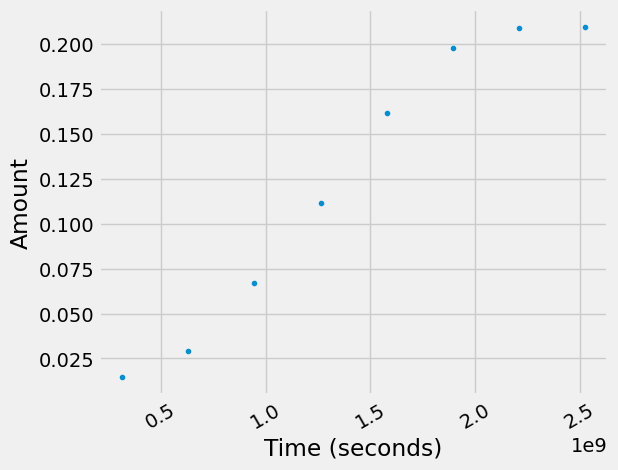

In [10]:
inc_wind_turbine_energy_relative = bwt.TemporalDistribution(
    date=delta,
    amount=a
)
inc_wind_turbine_energy_relative.graph()

In [17]:
del bd.databases['wind-example']

In [19]:
generated_electricity_over_lifetime = 4.38e9 / 1e3 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.8
LT = 25 # 25 years lifetime of a wind turbine

bd.Database('wind-example').write({
    ('wind-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 0.9,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'operational-wind-turbine'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
                'temporal_distribution' : inc_wind_turbine_energy_relative, #we would prefer to use the absolute TD, but for some reason the graph reversal isn't working with it...
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
        ('wind-example', 'operational-wind-turbine'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': bwt.easy_timedelta_distribution(
                    start=-1,
                    end=1,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=3,
                    # kind = '',
                    # param = 0
                ),
            },
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': bwt.easy_timedelta_distribution(
                    start=20,
                    end=30,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=11,
                    kind = 'normal',
                    param = 0.1
                )
            },
            # CO2 emissions corresponding to maintenance
            # {
            #     'input': ('wind-example', 'CO2'),
            #     'amount': 100,
            #     'type': 'biosphere',
            # }
        ]
    },
    ('wind-example', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 200000,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e6,
                'type': 'biosphere',
            } #taking into account CO2 of machine and materials, not just operational energy
        ]
    },
    ('wind-example', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e5,
                'type': 'biosphere',
            }, #taking into account CO2 of machines and materials, not just operational energy
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 1e5,
                'type': 'technosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 8/8 [00:00<00:00, 112222.18it/s]

Vacuuming database 


In [ ]:
lca = bc.LCA({('wind-example', 'electricity-production-wind'): 1}, ("GWP", "wind-example"))
lca.lci()
lca.lcia()
lca.score

In [ ]:
tlca = bwt.TemporalisLCA(lca)

In [ ]:
tl = tlca.build_timeline()

In [ ]:
import seaborn as sb
import pandas as pd

In [ ]:
df = tl.build_dataframe()
df = tl.add_metadata_to_dataframe(['wind-example'])

In [ ]:
# df

In [ ]:
df2  = bd.Database('wind-example').nodes_to_dataframe()

In [ ]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'activity_name',
    data = df.merge(
        df2.rename(columns={'id' : 'activity'}), on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time")
axes.set_xlim(xmax=np.datetime64(100, 'Y'))
axes.set_ylim(ymax=0.05)
axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service